# Finetune invoice classification model

In [1]:
import numpy as np
import mlflow
from datasets import load_from_disk, load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, Trainer, TrainingArguments

from src.config import init_config
from src.metrics import compute_metrics, cfm_metric
from src.visuals import plot_confusion_matrix

## Config and settings

In [2]:
config = init_config(overrides=["+train=full"])

In [3]:
print(config)

data:
  fatura: mathieu1256/FATURA2-invoices
  rvl_cdip_subset: jinhybr/rvl_cdip_400_train_val_test
  invoiceXpert:
    hf_path: wiF0n/InvoiceXpert
    local_path: data/invoiceXpert
    num_labels: 2
    label_col: label
    image_col: image
    label_names:
    - invoice
    - not-invoice
models:
  classification:
    oob:
      pt: microsoft/dit-base
      ft: microsoft/dit-base-finetuned-rvlcdip
mlflow:
  experiments:
    classification: invoice-classification
utils:
  seed: 420
  run_date: 2024-16-02/25/24
train:
  output_dir: ./models/full_ft
  overwrite_output_dir: true
  do_train: true
  do_eval: true
  evaluation_strategy: steps
  eval_steps: 100
  num_train_epochs: 3
  per_device_train_batch_size: 32
  per_device_eval_batch_size: 64
  learning_rate: 5.0e-05
  logging_strategy: steps
  logging_steps: 10
  save_strategy: steps
  save_total_limit: 1
  bf16: true
  dataloader_num_workers: 4
  load_best_model_at_end: true
  report_to: mlflow
  remove_unused_columns: false



In [4]:
experiment = mlflow.set_experiment(config.mlflow.experiments.classification)

## Load the model

In [5]:
image_processor = AutoImageProcessor.from_pretrained(config.models.classification.oob.pt)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
/home/david/code/InvoiceXpert/.venv/lib/python3.10/site-packages/transformers/models/beit/image_processing_beit.py:111: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [6]:
model = AutoModelForImageClassification.from_pretrained(config.models.classification.oob.pt, num_labels=2, ignore_mismatched_sizes=True)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load and preprocess the data

In [7]:
invoice_df = load_from_disk(config.data.invoiceXpert.local_path, keep_in_memory=True)

In [8]:
def preprocess_function(examples):
    examples["pixel_values"] = image_processor(examples["image"])["pixel_values"]
    del examples["image"]
    return examples

In [9]:
prepped_df = invoice_df.with_transform(preprocess_function)

## Trainer

In [10]:
training_args = TrainingArguments(**config.train)

In [11]:
run = mlflow.start_run(experiment_id=experiment.experiment_id, run_name="dit-base-invoiceXpert-full-ft")

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepped_df["train"],
    eval_dataset=prepped_df["validation"],
    compute_metrics=compute_metrics
)

In [13]:
trainer.train()
trainer.save_model()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.141600,0.076078,0.974063,0.972416,0.969516,0.975333
200,0.072800,0.052512,0.983750,0.982793,0.975690,0.990000
300,0.066700,0.065163,0.982500,0.981603,0.967617,0.996000
400,0.071100,0.055730,0.980000,0.979030,0.962629,0.996000
500,0.026800,0.082634,0.978125,0.977139,0.957746,0.997333
600,0.016000,0.047491,0.987187,0.986374,0.983433,0.989333
700,0.029200,0.044839,0.988437,0.987744,0.981567,0.994000
800,0.016200,0.045102,0.987187,0.986320,0.987308,0.985333
900,0.066600,0.055496,0.987812,0.987022,0.985382,0.988667
1000,0.053600,0.060052,0.986875,0.986129,0.977094,0.995333


Checkpoint destination directory ./models/full_ft/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


In [14]:
trainer.evaluate()

{'eval_loss': 0.06005182862281799,
 'eval_accuracy': 0.986875,
 'eval_f1': 0.9861294583883752,
 'eval_precision': 0.9770942408376964,
 'eval_recall': 0.9953333333333333,
 'eval_runtime': 12.8909,
 'eval_samples_per_second': 248.237,
 'eval_steps_per_second': 3.879,
 'epoch': 3.0}

In [15]:
trainer.evaluate(eval_dataset=prepped_df["test"], metric_key_prefix="test")

{'test_loss': 0.0635773241519928,
 'test_accuracy': 0.9873333333333333,
 'test_f1': 0.9874088800530152,
 'test_precision': 0.9815546772068511,
 'test_recall': 0.9933333333333333,
 'test_runtime': 12.2003,
 'test_samples_per_second': 245.895,
 'test_steps_per_second': 3.852,
 'epoch': 3.0}

In [16]:
eval_preds = trainer.predict(prepped_df["validation"])
test_preds = trainer.predict(prepped_df["test"])

In [17]:
eval_cfm = cfm_metric.compute(references=eval_preds.label_ids, predictions=np.argmax(eval_preds.predictions, axis=-1))["confusion_matrix"]
test_cfm = cfm_metric.compute(references=test_preds.label_ids, predictions=np.argmax(test_preds.predictions, axis=-1))["confusion_matrix"]

Confusion matrix, without normalization
[[1665   35]
 [   7 1493]]


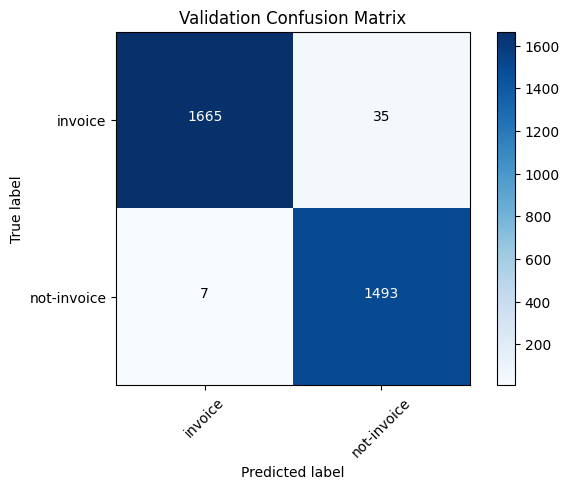

In [18]:
eval_cfm_plot = plot_confusion_matrix(eval_cfm, classes=config.data.invoiceXpert.label_names, title="Validation Confusion Matrix")

Confusion matrix, without normalization
[[1472   28]
 [  10 1490]]


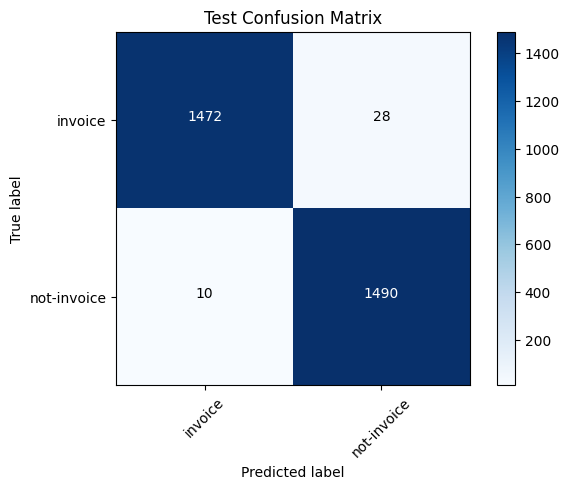

In [19]:
test_cfm_plot = plot_confusion_matrix(test_cfm, classes=config.data.invoiceXpert.label_names, title="Test Confusion Matrix")

In [20]:
mlflow.log_figure(eval_cfm_plot, "validation_confusion_matrix.png")
mlflow.log_figure(test_cfm_plot, "test_confusion_matrix.png")

In [21]:
mlflow.end_run()